# Assignment 9: PyTorch

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

- *Your names here*

**If you wish to present any of the tasks, please tell us here.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Package name: scikit-image, requires installation of package 'Pillow'
import skimage.io
import skimage.transform
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import sklearn

In [29]:
def load_airfoil_dataset():
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    data = np.genfromtxt('airfoil_self_noise.csv')
    X, y = data[:, :5], data[:, 5]
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    return X_train, X_test, y_train, y_test


def load_traffic_sign_dataset(task3=False):
    import os
    
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        images = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".ppm")]
            for f in file_names:
                images.append(skimage.io.imread(f))
                labels.append(int(d))
        images, labels = np.array(images), np.array(labels)
        if not task3:
            images = np.array([skimage.transform.resize(img, (50, 50)) for img in images])
        else:
            images = np.array([skimage.transform.resize(img, (128, 128)) for img in images])
        return images, labels
            
    X_train, y_train = load_data('Training')
    X_test, y_test = load_data('Testing')
    
    return X_train, X_test, y_train, y_test


In [4]:
class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

    



class FlattenedImageDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = np.array([img.flatten() for img in X])
        self.y = y
        
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]


## Task 1: Linear Regression with SGD in PyTorch

In this first task, you will implement a linear regression model in PyTorch without using the existing [`torch.nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) module. Instead use basic math operations such as addition and matrix multiplication for the computation of the forward pass. The computation of gradients and performing backpropagation will be automatically handled by PyTorch.

Initialize the weights and bias of the linear model using the standard Gaussian distribution similar to Assignment 8 - Task 3. The `bias` parameter selects whether a bias term should be included in the model.

*Hint:* To allow training of the network, the weights of the model have to be made trainable. A convenient way to do this is to instantiate the learnable parameters as [`torch.nn.Parameter`](https://pytorch.org/docs/master/generated/torch.nn.parameter.Parameter.html) objects and set them as fields of a [`torch.nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) subclass.

In [5]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features ,depth, width,lr,bias=True):
        super(MyLinear,self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
       
        self.myParameters={}
        self.depth=depth
        
        
        
        
        # Your initialization code comes here.
#         定义权重 w0是input weight, w(depth+1) is output weight
#         self.w0=torch.randn(in_features,width,requires_grad=True)
        self.myParameters['w0']=torch.randn(in_features,width,requires_grad=True)
        
#         names=self.__dict__
        for i in range(0,depth):
            self.myParameters['w'+str(i+1)]=torch.randn(width,width,requires_grad=True)
#             self.myParameters.append(nn.Parameter(names['w'+str(i+1)]))
        self.myParameters['w'+str(depth+1)]=torch.randn(width,out_features,requires_grad=True)
#         self.myParameters.append(nn.Parameter(names['w'+str(depth+1)]))
#     定义b b0 is input bias, b(depth +1) is output bias
#         if bias:
        self.myParameters['b0']=torch.randn(1,width,requires_grad=True)
        for i in range(0,depth):
            self.myParameters['b'+str(i+1)]=torch.randn(1,width,requires_grad=bias)
#           self.myParameters.append(nn.Parameter(names['b'+str(i+1)]))
        self.myParameters['b'+str(depth+1)]=torch.randn(1,out_features,requires_grad=bias)
#             self.myParameters.append(nn.Parameter(names['b'+str(depth+1)]))
#         else:
#             self.b0=torch.zeros(1,width)
#             for i in range(0,depth):
#                 names['b'+str(i+1)]=torch.zeros(1,width,requires_grad=False)
# #                 self.myParameters.append(nn.Parameter(names['b'+str(i+1)]))
#             names['b'+str(depth+1)]=torch.zeros(1,out_features,requires_grad=False)
# #             self.myParameters.append(nn.Parameter(names['b'+str(depth+1)]))
        
#         self.parameters=self.myParameters
        for key,value in self.myParameters.items():
            self.register_parameter(name=key,param=nn.parameter.Parameter(value))
    
    def forward(self, X):
        # The forward pass of the linear regression comes here.
#         names=self.__dict__
        for name,parameter in self.named_parameters():
            self.myParameters[name]=parameter
        y_pred=(X.mm(self.myParameters['w0']).add(self.myParameters['b0']))
        for i in range(0,self.depth):
            y_pred=F.relu(y_pred.mm(self.myParameters['w'+str(i+1)]).add(self.myParameters['b'+str(i+1)]))
        y_pred=y_pred.mm(self.myParameters['w'+str(self.depth+1)]).add(self.myParameters['b'+str(self.depth+1)])
        
        
        
        return y_pred


We provide you with the necessary code to train and compare your model and the reference implementation of PyTorch. You will have to replicate similar training code for multi-class classification in Task 2.

In [6]:
from sklearn.linear_model import LinearRegression

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 25
in_features = 5
out_features = 1

# Initialize models.
my_linear = MyLinear(in_features, out_features,1,10,learning_rate)
pt_linear = nn.Linear(in_features, out_features)

# Load dataset.
X_train, X_test, y_train, y_test = load_airfoil_dataset()
dataset_train = BasicDataset(X_train, y_train)


def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = F.mse_loss(yhat, batch['y'].float())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

        
def evaluate_model(model, X_test, y_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model.forward(X_test).detach().numpy()
    mse = np.mean(np.power(yhat - y_test, 2))
    print('Test MSE:', mse)
    

print('MyLinear')
train_model(my_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(my_linear, X_test, y_test)
print()
print('torch.nn.Linear')
train_model(pt_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(pt_linear, X_test, y_test)
print()
print('sklearn.linear_model.LinearRegression')
print('Test MSE:', np.mean(np.power(LinearRegression().fit(X_train, y_train).predict(X_test) - y_test, 2)))

MyLinear
Epoch 1/25 - Loss: 882.301008105278
Epoch 2/25 - Loss: 14.5684295296669
Epoch 3/25 - Loss: 12.961456537246704
Epoch 4/25 - Loss: 11.841538906097412
Epoch 5/25 - Loss: 10.777201116085052
Epoch 6/25 - Loss: 9.681110382080078
Epoch 7/25 - Loss: 9.086161434650421
Epoch 8/25 - Loss: 8.443072229623795
Epoch 9/25 - Loss: 8.14347094297409
Epoch 10/25 - Loss: 7.870451897382736
Epoch 11/25 - Loss: 7.574602246284485
Epoch 12/25 - Loss: 7.35596838593483
Epoch 13/25 - Loss: 7.229089081287384
Epoch 14/25 - Loss: 7.0394586622715
Epoch 15/25 - Loss: 6.966067433357239
Epoch 16/25 - Loss: 6.780141294002533
Epoch 17/25 - Loss: 6.731151968240738
Epoch 18/25 - Loss: 6.6460162699222565
Epoch 19/25 - Loss: 6.487082302570343
Epoch 20/25 - Loss: 6.380259126424789
Epoch 21/25 - Loss: 6.3088687509298325
Epoch 22/25 - Loss: 6.204810827970505
Epoch 23/25 - Loss: 6.0445036590099335
Epoch 24/25 - Loss: 5.943446561694145
Epoch 25/25 - Loss: 5.806715309619904
Test MSE: 0.31166498216569133

torch.nn.Linear
Epo

## Task 2: Image Classification with FNN

In this task, you will implement an FNN for multi-class classification of traffic signs.

Download the [training](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip) and [test](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip) data. Unpack the zip-files in the same directory as the Jupyter notebook.

The shape of each image is `(width=50, height=50, channels=3)` after resizing. The channels represent the color of each pixel.
FNN cannot directly operate on images. We therefore have to flatten each image to a vector.
We achieve this with the [`numpy.flatten`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) method. The class `FlattenedImageDataset` may be used for training of your FNN.

Implement a feedforward neural network with multiple layers using either [`nn.Sequential`](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html) class or by subclassing [`nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) as shown in Task 1.  Use a combination [`nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and activation functions (e.g. [`nn.ReLU`](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) to implement the fully connected layers of an FNN. Experiment with different activation functions (ReLU, tanh, ...), different depths, and widths. Use the Adam optimizer ([`optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)) for optimization.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* You may modify the code from Task 1. However, you need to use an appropriate loss function and output layer for your FNN to train your network for multi-class classification. Use your knowledge from the lecture to identify the correct methods in the [PyTorch documentation](https://pytorch.org/docs/stable/index.html).

In [44]:
# Load training and testing data.
X_train, X_test, y_train, y_test = load_traffic_sign_dataset()
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('Image shape:', X_train[0].shape)
print('#Classes:', len(np.unique(y_train)))

Training samples: 4575
Testing samples: 2520
Image shape: (50, 50, 3)
#Classes: 62


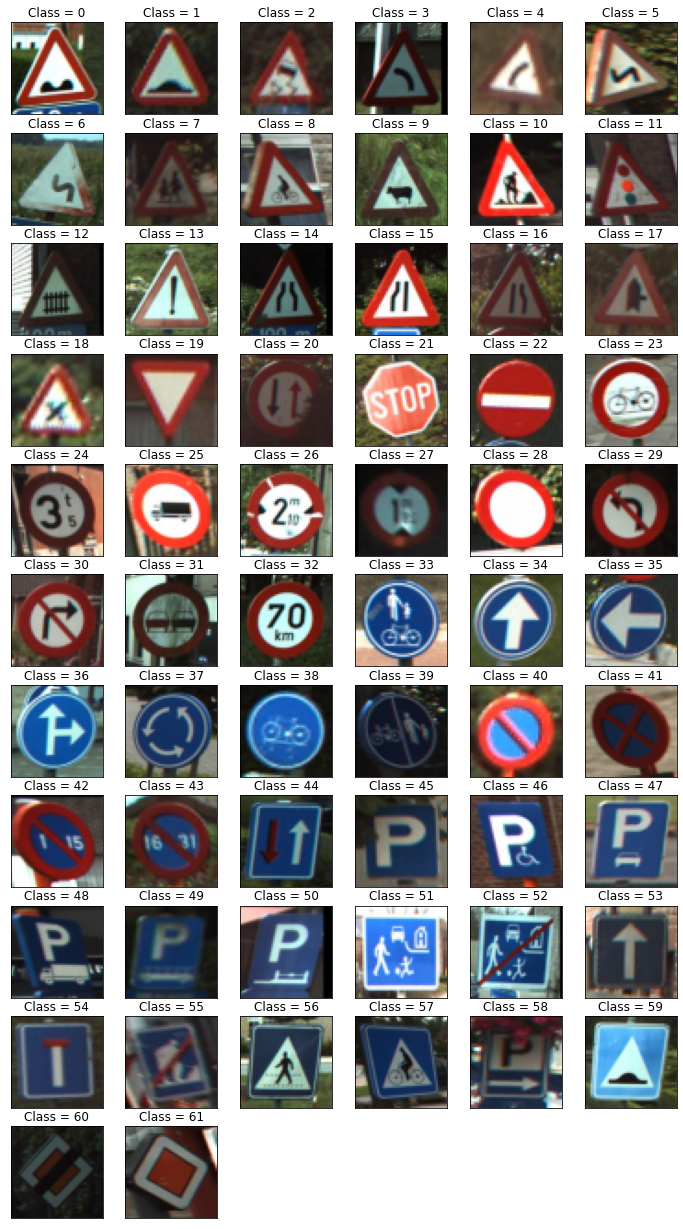

In [45]:
# Show sample for each class.
class_labels = set(np.unique(y_train))
n_classes = len(class_labels)

n_cols = 6
n_rows = n_classes // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for label in sorted(class_labels):
    row = label // n_cols
    col = label % n_cols
    img_idx = np.argmax(y_train == label)
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title(f'Class = {label}')
    
leftover_subplots = n_cols - (max(class_labels) % n_cols) - 1
for i in range(leftover_subplots):
    fig.delaxes(ax[-1, -(i+1)])

In [46]:
# Implement your model and training here.
flattenDatasetTrain=FlattenedImageDataset(X_train,y_train)
flattenDatasetTest=FlattenedImageDataset(X_test,y_test)


def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            
            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())
            # print(yhat)
            

            # Compute the batch error.
            batch_loss = nn.CrossEntropyLoss()
            loss=batch_loss(yhat, batch['y'].long())
            epoch_loss += loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')
myModel=nn.Sequential(
            nn.Linear(7500,100,True),
            nn.ReLU(),
            nn.Linear(100,100,True),
            nn.ReLU(),
            nn.Linear(100,100,True),
            nn.ReLU(),
            nn.Linear(100,62,True),
            nn.LogSoftmax()
            )

train_model(myModel,flattenDatasetTrain,learning_rate,62,150)
res=[]
print(len(flattenDatasetTest))
test_data_loader=data.DataLoader(dataset=flattenDatasetTest).

for batch in test_data_loader:
    y_pred=myModel.forward(batch['X'].float())
    res.append(torch.argmax(y_pred))
    # print(y_pred)
# print(res)
acc=sklearn.metrics.accuracy_score(res,y_test)
# f1=sklearn.metrics.f1_score(res,y_test)
cm=sklearn.metrics.confusion_matrix(res,y_test)
print("____________________")
print("accuracy is %f" %acc)
print("____________________")
sklearn.metrics.classification_report(res,y_test)
# print("f1 Score is %f" %f1)
# sklearn.metrics.ConfusionMatrixDisplay(cm).plot()

Epoch 1/150 - Loss: 213.26032280921936
Epoch 2/150 - Loss: 120.6228369474411
Epoch 3/150 - Loss: 104.30905663967133
Epoch 4/150 - Loss: 92.89245945215225
Epoch 5/150 - Loss: 79.95187604427338
Epoch 6/150 - Loss: 66.32134506106377
Epoch 7/150 - Loss: 58.16817885637283
Epoch 8/150 - Loss: 54.036847561597824
Epoch 9/150 - Loss: 55.66055250167847
Epoch 10/150 - Loss: 43.794226467609406
Epoch 11/150 - Loss: 40.84527713060379
Epoch 12/150 - Loss: 44.15194709599018
Epoch 13/150 - Loss: 39.87058725953102
Epoch 14/150 - Loss: 46.34960696101189
Epoch 15/150 - Loss: 51.784361600875854
Epoch 16/150 - Loss: 41.69589513540268
Epoch 17/150 - Loss: 45.21427425742149
Epoch 18/150 - Loss: 42.15600563585758
Epoch 19/150 - Loss: 39.42754131555557
Epoch 20/150 - Loss: 36.75117139518261
Epoch 21/150 - Loss: 39.024062395095825
Epoch 22/150 - Loss: 34.52649836242199
Epoch 23/150 - Loss: 30.723592877388
Epoch 24/150 - Loss: 33.84622760117054
Epoch 25/150 - Loss: 28.018515564501286
Epoch 26/150 - Loss: 29.26690

'              precision    recall  f1-score   support\n\n           0       0.50      0.50      0.50         6\n           1       0.96      0.84      0.90        31\n           2       0.29      0.25      0.27         8\n           3       0.00      0.00      0.00         5\n           4       0.00      0.00      0.00         0\n           5       0.00      0.00      0.00         1\n           6       0.00      0.00      0.00         6\n           7       0.93      0.66      0.77       127\n           8       0.00      0.00      0.00         5\n           9       0.00      0.00      0.00         2\n          10       0.46      0.93      0.62        14\n          11       0.00      0.00      0.00         3\n          12       0.00      0.00      0.00         1\n          13       0.08      0.75      0.14         4\n          14       0.40      0.17      0.24        36\n          15       0.00      0.00      0.00         6\n          16       0.00      0.00      0.00         1\n       

## Task 3: Image Classification with CNN

*For all students other than B.Sc. Data Science.*

In this task, you will implement a convolutional neural network (CNN) for classification of traffic signs.
Your model should use [`nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers to compute convolutions, any kind of pooling (e.g. [`nn.MaxPool2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d)), and a dense output network.
For inspiration look at the architecture of AlexNet (presented in the lecture).
For simplicity, you may use the `nn.Sequential` class.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* For the most part, you can reuse your code from Task 2. However, you have to use images in their original format `(128, 128, 3)` instead of the flattened shape.

In [47]:
X_train, X_test, y_train, y_test = load_traffic_sign_dataset(True)
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('Image shape:', X_train[0].shape)
print('#Classes:', len(np.unique(y_train)))

Training samples: 4575
Testing samples: 2520
Image shape: (128, 128, 3)
#Classes: 62


In [62]:
# Implement your model and training here.


class AlexNet(nn.Module):
    def __init__(self,num_classes=62):
        super(AlexNet,self).__init__()
        self.layer1=nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(3,48,kernel_size=11,stride=4),
            nn.ReLU(),
            nn.MaxPool2d(4,2)
        )
        self.layer2=nn.Sequential(
            # convolutional layer 2
            nn.Conv2d(48,128,kernel_size=5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,padding=1)
        )
        self.layer3=nn.Sequential(
             # convolutional layer 3
            nn.Conv2d(128,192,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        self.layer4=nn.Sequential(
            # convolutional layer 4
            nn.Conv2d(192,192,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
        )
        self.layer5=nn.Sequential(
            # convolutional layer5
            nn.Conv2d(192,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
            
        

        self.denseLayer=nn.Sequential(
            # Dense layer 1
            nn.Dropout(p=0.5),
            nn.Linear(128*3*3,1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Dense layer 2
            nn.Linear(1024,1024),
            nn.ReLU(),
            # Output Layer
            nn.Linear(1024,num_classes)
        )

    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.layer5(out)
        # print(out.size())
        out=out.view(-1,128*3*3)
        out=self.denseLayer(out)
        return(out)
print(X_train.shape)
if X_train.shape[1]!=3:
    X_train=torch.from_numpy(X_train)
    print(X_train.shape)
    X_train=X_train.permute(0,3,2,1).numpy()
    print(X_train.shape)
if X_test.shape[1]!=3:
    X_test=torch.from_numpy(X_test)
    print(X_test.shape)
    X_test=X_test.permute(0,3,2,1).numpy()
    print(X_test.shape)

dataset=BasicDataset(X_train,y_train)
myModel=AlexNet(62)
train_model1(myModel,dataset,learning_rate,62,10)

res=[]
test_dataset=BasicDataset(X_test,y_test)
test_data_loader=data.DataLoader(dataset=test_dataset)
for batch in test_data_loader:
    y_pred=myModel.forward(batch['X'].float())
    res.append(torch.argmax(y_pred))
    # print(y_pred)
print(len(res))
print(y_test.shape)
acc=sklearn.metrics.accuracy_score(res,y_test)
# f1=sklearn.metrics.f1_score(res,y_test)
cm=sklearn.metrics.confusion_matrix(res,y_test)
print("____________________")
print("accuracy is %f" %acc)
print("____________________")
sklearn.metrics.classification_report(res,y_test)

(4575, 3, 128, 128)
Epoch 1/10 - Loss: 1747.980720758438
Epoch 2/10 - Loss: 264.5328965187073
Epoch 3/10 - Loss: 264.1852960586548
Epoch 4/10 - Loss: 264.16718101501465
Epoch 5/10 - Loss: 263.95442175865173
Epoch 6/10 - Loss: 263.91463708877563
Epoch 7/10 - Loss: 263.9486827850342
Epoch 8/10 - Loss: 263.8766767978668
Epoch 9/10 - Loss: 263.61022543907166
Epoch 10/10 - Loss: 263.76351857185364
2520
(2520,)
____________________
accuracy is 0.024206
____________________


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         0\n           1       0.00      0.00      0.00         0\n           2       0.00      0.00      0.00         0\n           3       0.00      0.00      0.00         0\n           4       0.00      0.00      0.00         0\n           5       0.00      0.00      0.00         0\n           6       0.00      0.00      0.00         0\n           7       0.00      0.00      0.00         0\n           8       0.00      0.00      0.00         0\n          10       0.00      0.00      0.00         0\n          12       0.00      0.00      0.00         0\n          13       0.00      0.00      0.00         0\n          14       0.00      0.00      0.00         0\n          16       0.00      0.00      0.00         0\n          17       0.00      0.00      0.00         0\n          18       0.00      0.00      0.00         0\n          19       0.00      0.00      0.00         0\n       

In [12]:
# Implement your evaluation here.